In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import random
import os
import copy
import time
import math
from math import sqrt

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:",device)

device is: cuda


In [2]:
def metric(y_test, y_hat, log=False):
    MSE  = mean_squared_error(y_test, y_hat)
    RMSE = sqrt(MSE)
    MAE  = mean_absolute_error(y_test, y_hat)
    MAPE = mean_absolute_percentage_error(y_test, y_hat)
    R2   = r2_score(y_test, y_hat)
    
    if log:
        print(f'\
MSE...............{MSE:.4f}\n\
RMSE..............{RMSE:.4f}\n\
MAE...............{MAE:.4f}\n\
MAPE..............{MAPE:.4f}\n\
R2................{R2:.4f}\
              ')
    
    return [MSE, RMSE, MAE, MAPE, R2]

In [3]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
class ANN(nn.Module):
    def __init__(self, num_feature, num_class, layers_size, dropout=0):
        super(ANN, self).__init__()
        self.layers = nn.ModuleList()    
        self.layers.append(nn.Linear(num_feature, layers_size[0])) # входной слой
        for i in range(len(layers_size)-1):   
            self.layers.append(nn.Linear(layers_size[i], layers_size[i+1]))
        self.layers.append(nn.Linear(layers_size[-1], num_class)) # выходной слой

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [5]:
def train(num_epochs, model, dataset_train, dataset_val, optimizer, criterion, scaler, feature_dim, step_size,
          iter_log=10, show_plot=False, lr_scheduler=None, patience=200, one_line_log=False):
    start = time.time()
    train_loss_list, val_loss_list = [], []
    best_loss, best_acc = 999, 999
    no_improvement, no_increase = 0, 0
    early_stopping_increment = 1
    prev_test_loss = 999
    
    try:
        for epoch in range(1, num_epochs+1):
            model.train()
            train_loss = .0
            for x, y in dataset_train:
                y_pred = model(x.to(device))
                loss = criterion(y_pred, y.to(device))
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                train_loss += loss.item()
            train_loss_list.append(train_loss)

            model.eval()
            y_hat, y_act = [], []
            test_loss = .0
            with torch.no_grad():
                for x, y in dataset_val:
                    y_pred = model(x.to(device))
                    vall_loss = criterion(y_pred, y.to(device))
                    test_loss += vall_loss.item()
                    y_hat.append(y_pred.cpu())
                    y_act.append(y.cpu())
                y_hat = [element.tolist() for sublist in y_hat for element in sublist]
                y_act = [element.tolist() for sublist in y_act for element in sublist]

                y_hat = unscale(np.array(y_hat), feature_dim, scaler)
                y_act = unscale(np.array(y_act), feature_dim, scaler)
                
                val_loss_list.append(test_loss)
                test_score = metric(y_act, y_hat)[1]
                 
            # # #
            
            lr_scheduler.step(test_loss)
            
            if (epoch > 1) and val_loss_list[-2] < val_loss_list[-1]:
                no_increase += 1
            else:
                no_increase = 0
            
            if no_increase < 20:
                early_stopping_increment = 1
            elif no_increase < 40:
                early_stopping_increment = 2
            else:
                early_stopping_increment = 3
            
            if test_loss < best_loss:
                best_loss = test_loss
                best_model = copy.deepcopy(model.state_dict())
                no_improvement -= 10
                no_improvement = 0 if no_improvement < 0 else no_improvement
            else:
                no_improvement += early_stopping_increment
            
            if test_score < best_acc:
                best_acc  = test_score
                                            
            if epoch % iter_log == 0:
                if one_line_log:
                    print(f"Epoch: {epoch}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, test acc: {test_score:.2f}, best acc: {best_acc:.2f}, time: {timeSince(start, epoch/num_epochs)}, no improv.: {no_improvement}", end="")
                    print("\r", end="")
                else:
                    print(f"Epoch: {epoch}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, test acc: {test_score:.2f}, best acc: {best_acc:.2f}, time: {timeSince(start, epoch/num_epochs)}, no improv.: {no_improvement}")
                                   
            if no_improvement >= patience:
                print(f'Early stop at {epoch} epoch')
                break  
    
    except KeyboardInterrupt:
        print(f'Interrupted at {epoch} epoch')
        
    model.load_state_dict(best_model)
    
    if show_plot:
        plt.plot(train_loss_list[10:], c='tab:blue')
        plt.gca().twinx().plot(val_loss_list[10:], label='val', c='tab:red')
        plt.title(f'best acc - {best_acc:.4f}, best loss - {best_loss:.4f}')
        plt.legend()
        plt.show()
    
    return model

In [6]:
def unscale(data, dim, scaler):
    trainPredict_dataset_like = np.zeros(shape=(len(data), dim))
    trainPredict_dataset_like[:,0] = data[:,0]
    trainPredict = scaler.inverse_transform(trainPredict_dataset_like)[:,0]
    return trainPredict

In [7]:
# загрузка датасета
file_name = 'classification_data'

df = pd.read_pickle(f"DATASET\\{file_name}.pkl")
df

,ats_price,node_price,workday,weekend,shortday,holiday,month,day,hour,day_of_week,year,index,load_planned_sobr,generate_planned_sobr,T2M
2019-09-15 00:00:00,534.150024,596.798035,0.0,1.0,0.0,0.0,9.0,15.0,0.0,6.0,2019.0,67536.0,3314.781006,1855.880005,6.78
2019-09-15 01:00:00,534.219971,596.328613,0.0,1.0,0.0,0.0,9.0,15.0,1.0,6.0,2019.0,67537.0,3299.569092,2000.879028,7.56
2019-09-15 02:00:00,531.450012,594.732117,0.0,1.0,0.0,0.0,9.0,15.0,2.0,6.0,2019.0,67538.0,3342.320068,2000.879028,8.67
2019-09-15 03:00:00,524.900024,590.206787,0.0,1.0,0.0,0.0,9.0,15.0,3.0,6.0,2019.0,67539.0,3368.802002,1855.880005,9.66
2019-09-15 04:00:00,658.750000,721.414429,0.0,1.0,0.0,0.0,9.0,15.0,4.0,6.0,2019.0,67540.0,3534.553955,1886.124023,10.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01 19:00:00,1264.670044,1307.668457,1.0,0.0,0.0,0.0,8.0,1.0,19.0,0.0,2022.0,92779.0,3144.154053,2140.100098,14.07
2022-08-01 20:00:00,1240.239990,1285.128174,1.0,0.0,0.0,0.0,8.0,1.0,20.0,0.0,2022.0,92780.0,3053.440918,2140.100098,13.66
2022-08-01 21:00:00,1139.569946,1182.494141,1.0,0.0,0.0,0.0,8.0,1.0,21.0,0.0,2022.0,92781.0,3027.010010,2150.100098,13.30
2022-08-01 22:00:00,1048.040039,1084.094604,1.0,0.0,0.0,0.0,8.0,1.0,22.0,0.0,2022.0,92782.0,3027.762939,1847.401001,13.08


MSE...............1468.6934
RMSE..............38.3235
MAE...............37.0680
MAPE..............0.0288
R2................0.9776              


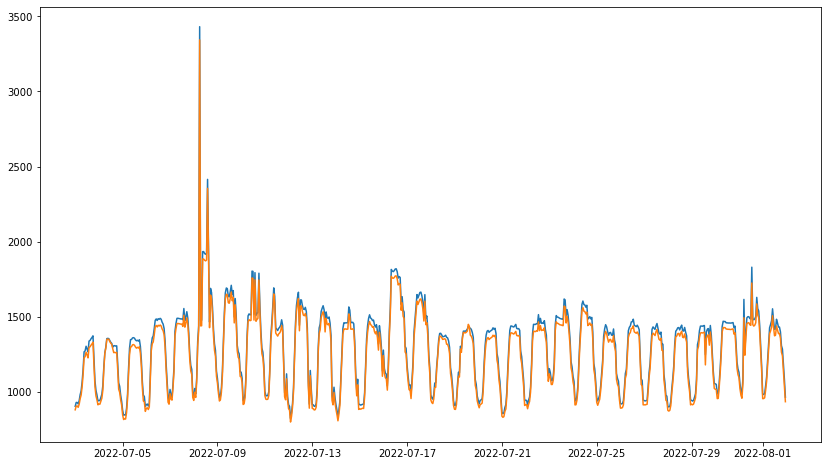

In [8]:
plt.figure(figsize=(14,8))
yact = df['node_price'].iloc[-720:]
yhat = df['ats_price'].iloc[-720:]
plt.plot(yact, label='actual (node_price)')
plt.plot(yhat, label='predicted (ats_price)')
metric(yact, yhat, log=True);

In [12]:
val_len    = 0.2
test_len   = 720
batch_size = 512

X = df[['node_price', 'month']].copy()
y = pd.merge(df[['ats_price']], X.drop(columns='node_price'), left_index=True, right_index=True)
X = X.to_numpy()
y = y.to_numpy()

X_train_val = X[:len(X) - test_len]
y_train_val = y[:len(y) - test_len]

X_test      = X[len(X) - test_len:]
y_test      = y[len(y) - test_len:]
X_train     = X_train_val[:int(len(X_train_val)*(1-val_len))]
y_train     = y_train_val[:int(len(y_train_val)*(1-val_len))]
X_val       = X_train_val[int(len(X_train_val)*(1-val_len)):]
y_val       = y_train_val[int(len(y_train_val)*(1-val_len)):]

scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
X_train, y_train = scaler.transform(X_train), scaler.transform(y_train)[:,0:1]
X_val, y_val     = scaler.transform(X_val), scaler.transform(y_val)[:,0:1]
X_test, y_test   = scaler.transform(X_test), scaler.transform(y_test)[:,0:1]

dataset_train = DataLoader(TensorDataset(torch.Tensor(X_train), 
                                         torch.Tensor(y_train)), 
                           batch_size=batch_size, shuffle=False)
dataset_val  = DataLoader(TensorDataset(torch.Tensor(X_val),  
                                        torch.Tensor(y_val)),  
                          batch_size=batch_size, shuffle=False)
dataset_test = DataLoader(TensorDataset(torch.Tensor(X_test),  
                                        torch.Tensor(y_test)),  
                          batch_size=batch_size, shuffle=False)

print('Train data shape:')
print(f'X_train -> {X_train.shape}')
print(f'y_train -> {y_train.shape}')
print('Val data shape:')
print(f'X_val -> {X_val.shape}')
print(f'y_val -> {y_val.shape}')
print('Test data shape:')
print(f'X_test -> {X_test.shape}')
print(f'y_test -> {y_test.shape}')

Train data shape:
X_train -> (19564, 2)
y_train -> (19564, 1)
Val data shape:
X_val -> (4892, 2)
y_val -> (4892, 1)
Test data shape:
X_test -> (720, 2)
y_test -> (720, 1)


Early stop at 1578 epoch 0.0070, test loss: 0.0034, test acc: 15.48, best acc: 15.48, time: 6m 4s (- 13m 10s), no improv.: 100


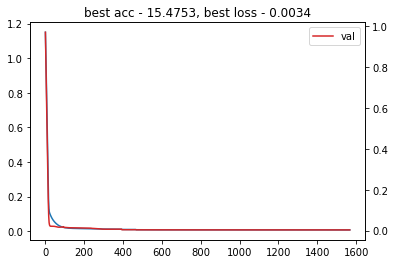

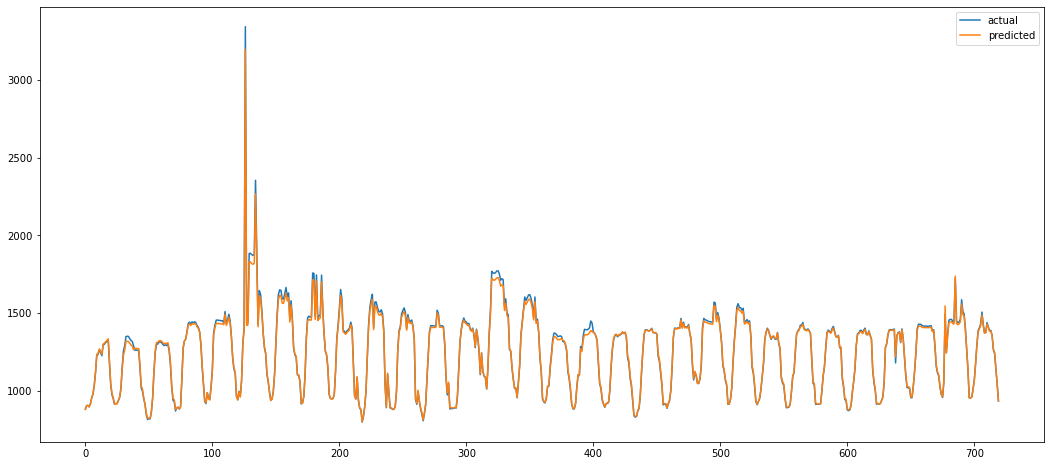

MSE...............251.8161
RMSE..............15.8687
MAE...............10.3967
MAPE..............0.0075
R2................0.9960              


In [13]:
num_epochs = 5000
LEARNING_RATE = 3e-4
pat = 100

NUM_FEATURES = X.shape[1]
NUM_CLASSES  = 1

seed_everything(SEED)

model = ANN(num_feature=NUM_FEATURES, num_class=NUM_CLASSES, layers_size=[32, 16, 6], dropout=0).to(device)

criterion = torch.nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=pat/2, min_lr=1e-5)

model = train(num_epochs=num_epochs,
              model=model, 
              dataset_train=dataset_train, 
              dataset_val=dataset_val, 
              optimizer=optimizer, 
              criterion=criterion, 
              scaler=scaler, 
              feature_dim=NUM_FEATURES, 
              step_size=None,
              iter_log=1, 
              show_plot=True, 
              lr_scheduler=lr_scheduler, 
              patience=pat, 
              one_line_log=True)

# # #

model.eval()
y_hat, y_act = [], []
with torch.no_grad():
    for x, y in dataset_test:
        y_pred = model(x.to(device))
        y_hat.append(y_pred.cpu())
        y_act.append(y.cpu())
    y_hat = [element.tolist() for sublist in y_hat for element in sublist]
    y_act = [element.tolist() for sublist in y_act for element in sublist]
    
    y_hat = unscale(np.array(y_hat), X_train.shape[1], scaler)
    y_act = unscale(np.array(y_act), X_train.shape[1], scaler)
    
plt.figure(figsize=(18,8))
plt.plot(y_act, label='actual')
plt.plot(y_hat, label='predicted')
plt.legend()
plt.show()

metric(y_act, y_hat, log=True);

In [15]:
pd.DataFrame({'yact' : y_act, 'yhat' : y_hat}).to_pickle(f"DATASET\\MLP1day.pkl")

layers_size=[32]


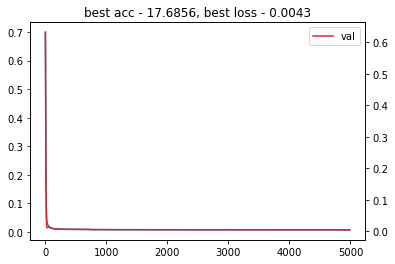

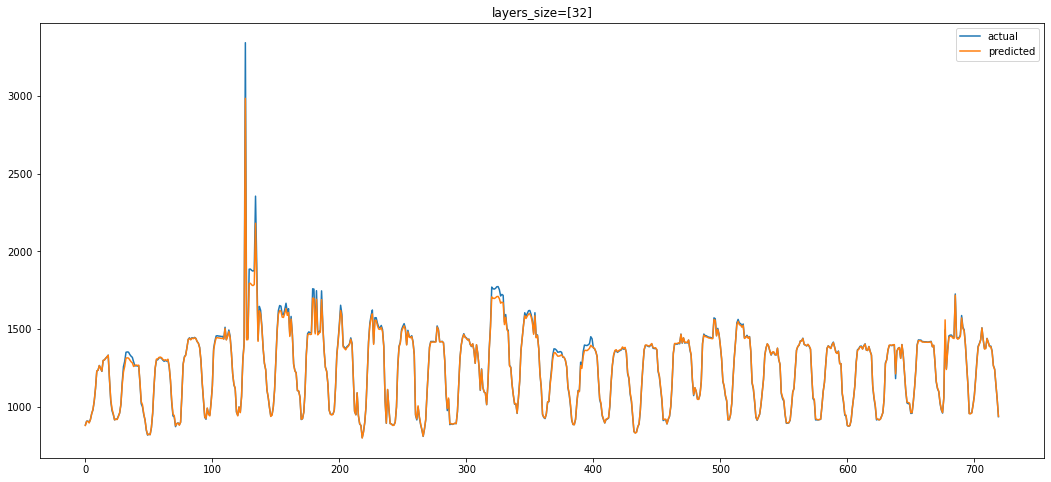

MSE...............447.8633
RMSE..............21.1628
MAE...............8.4007
MAPE..............0.0057
R2................0.9929              
layers_size=[64]
Early stop at 107 epoch 0.0127, test loss: 0.0110, test acc: 28.23, best acc: 27.97, time: 0m 22s (- 17m 16s), no improv.: 100


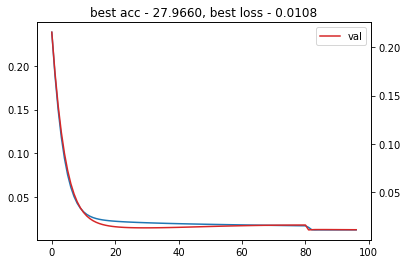

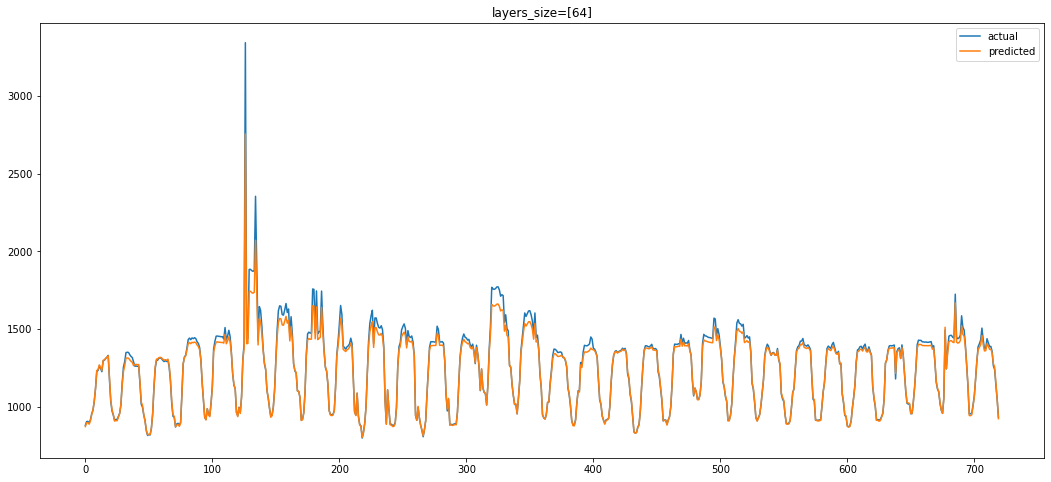

MSE...............1515.4925
RMSE..............38.9293
MAE...............19.9572
MAPE..............0.0134
R2................0.9758              
layers_size=[32, 16]
Early stop at 132 epoch 0.0123, test loss: 0.0072, test acc: 22.91, best acc: 20.72, time: 0m 29s (- 17m 52s), no improv.: 100


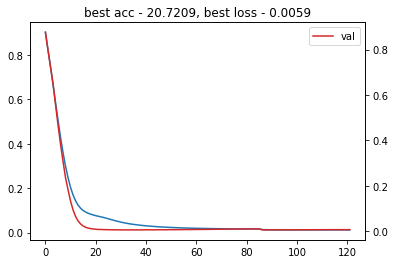

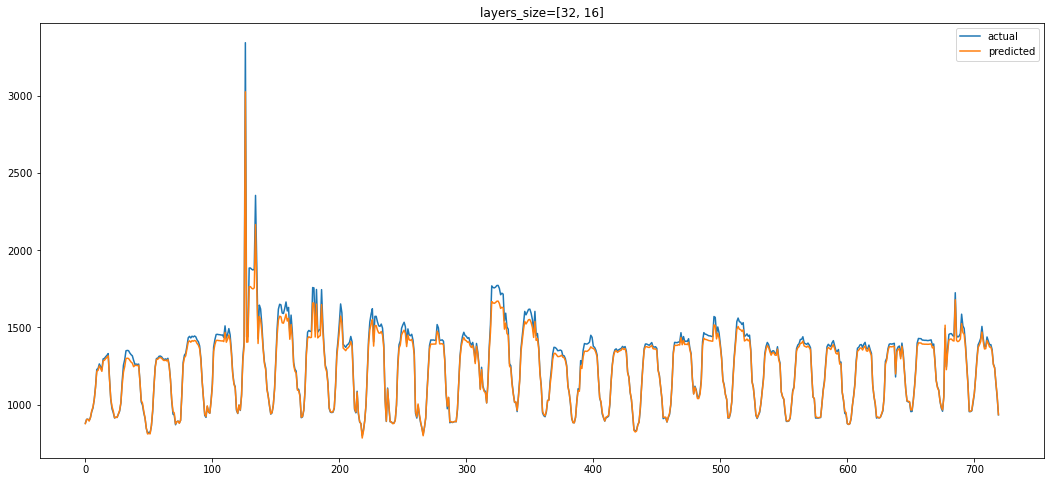

MSE...............1096.8863
RMSE..............33.1193
MAE...............21.5302
MAPE..............0.0149
R2................0.9825              
layers_size=[64, 32]
Early stop at 905 epoch 0.0107, test loss: 0.0067, test acc: 22.13, best acc: 15.26, time: 3m 18s (- 14m 58s), no improv.: 100


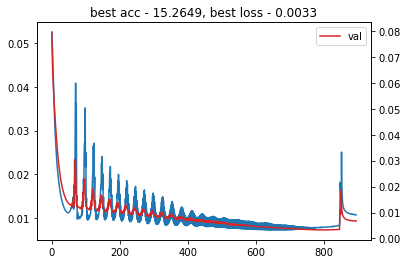

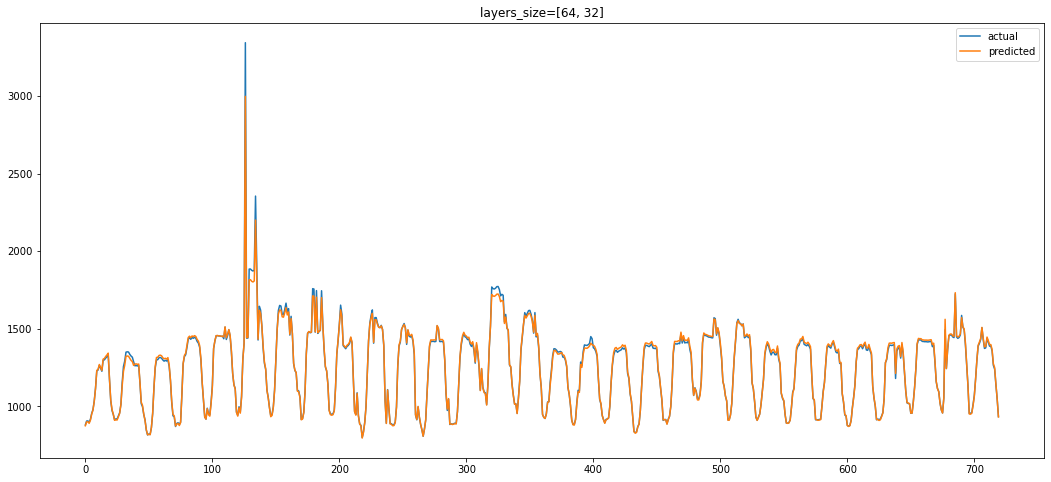

MSE...............382.9030
RMSE..............19.5679
MAE...............9.8419
MAPE..............0.0069
R2................0.9939              
layers_size=[32, 16, 6]
Early stop at 1578 epoch 0.0070, test loss: 0.0034, test acc: 15.48, best acc: 15.48, time: 6m 12s (- 13m 28s), no improv.: 100


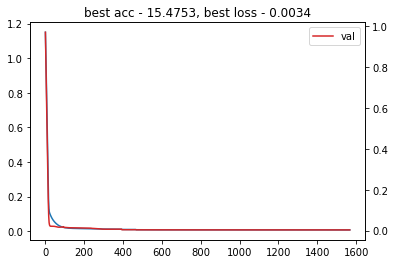

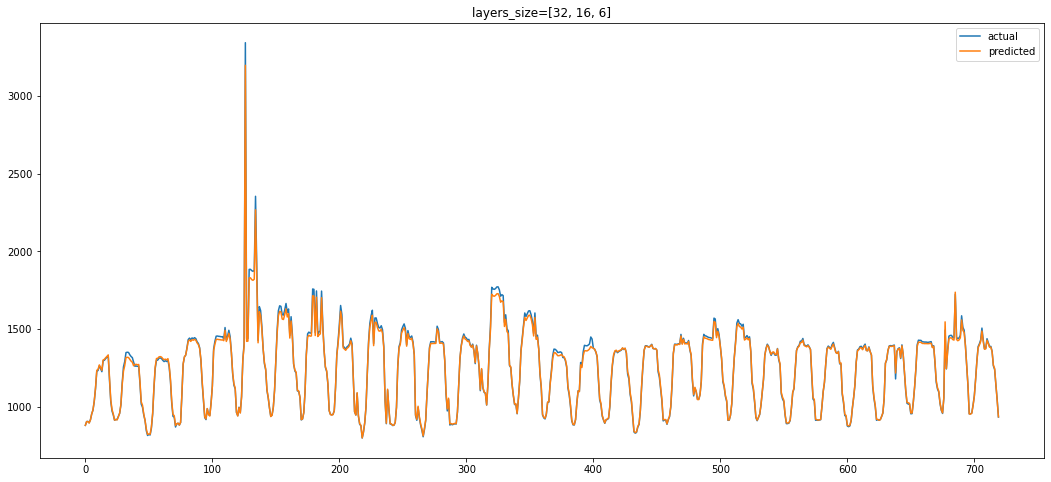

MSE...............251.8161
RMSE..............15.8687
MAE...............10.3967
MAPE..............0.0075
R2................0.9960              
layers_size=[64, 32, 16]
Early stop at 376 epoch 0.0092, test loss: 0.0085, test acc: 24.92, best acc: 23.89, time: 1m 27s (- 17m 55s), no improv.: 100


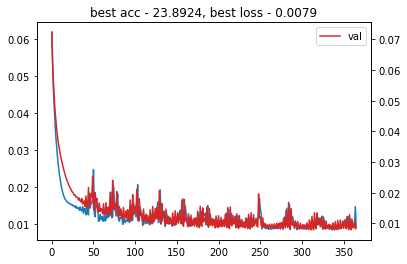

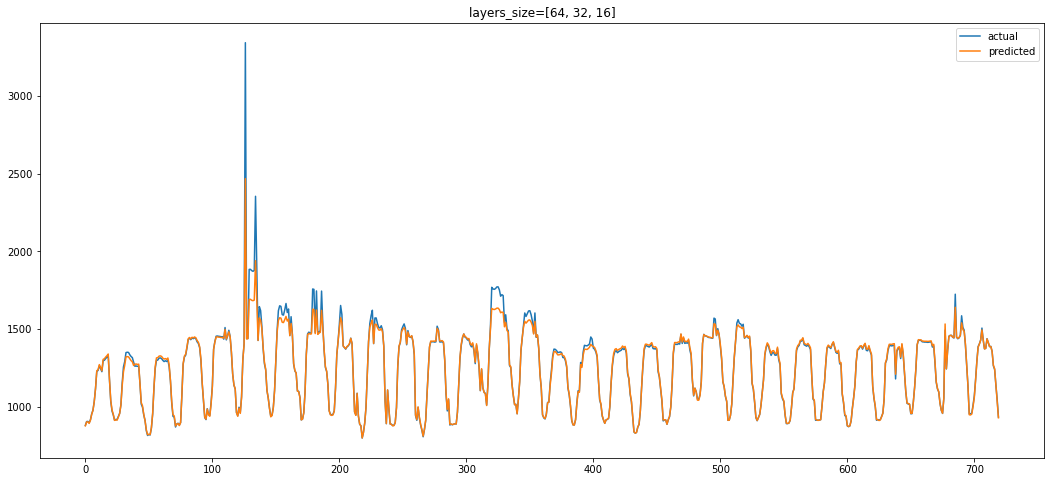

MSE...............2129.2661
RMSE..............46.1440
MAE...............14.1431
MAPE..............0.0089
R2................0.9660              
layers_size=[32, 16, 24, 6]
Early stop at 483 epoch 0.0108, test loss: 0.0114, test acc: 28.92, best acc: 24.15, time: 2m 4s (- 19m 19s), no improv.: 101


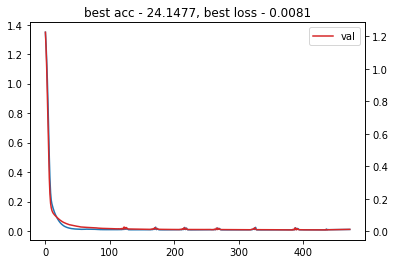

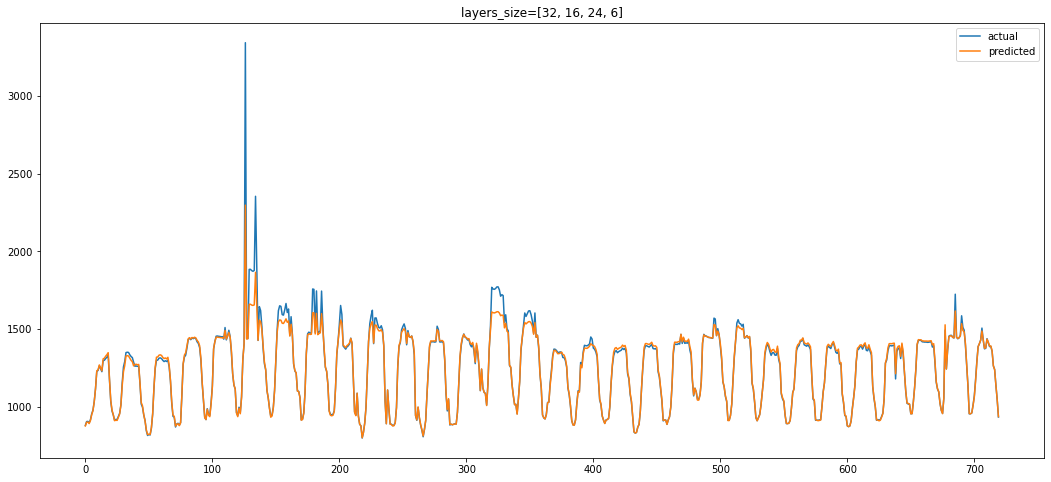

MSE...............2986.1785
RMSE..............54.6459
MAE...............16.9087
MAPE..............0.0107
R2................0.9523              


In [17]:
hid_size = [
    [32],
    [64],
    [32,16],
    [64,32],
    [32,16,6],
    [64,32,16],
    [32,16,24,6]
]

results = {}

for layers_size in hid_size:
    iter_name = f'layers_size={layers_size}'
    print(iter_name)

    num_epochs = 5000
    LEARNING_RATE = 3e-4
    pat = 100

    NUM_FEATURES = X.shape[1]
    NUM_CLASSES  = 1

    seed_everything(SEED)

    model = ANN(num_feature=NUM_FEATURES, num_class=NUM_CLASSES, layers_size=layers_size, dropout=0).to(device)

    criterion = torch.nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=pat/2, min_lr=1e-5)

    model = train(num_epochs=num_epochs,
                  model=model, 
                  dataset_train=dataset_train, 
                  dataset_val=dataset_val, 
                  optimizer=optimizer, 
                  criterion=criterion, 
                  scaler=scaler, 
                  feature_dim=NUM_FEATURES, 
                  step_size=None,
                  iter_log=1, 
                  show_plot=True, 
                  lr_scheduler=lr_scheduler, 
                  patience=pat, 
                  one_line_log=True)

    # # #

    model.eval()
    y_hat, y_act = [], []
    with torch.no_grad():
        for x, y in dataset_test:
            y_pred = model(x.to(device))
            y_hat.append(y_pred.cpu())
            y_act.append(y.cpu())
        y_hat = [element.tolist() for sublist in y_hat for element in sublist]
        y_act = [element.tolist() for sublist in y_act for element in sublist]

        y_hat = unscale(np.array(y_hat), X_train.shape[1], scaler)
        y_act = unscale(np.array(y_act), X_train.shape[1], scaler)

    plt.figure(figsize=(18,8))
    plt.plot(y_act, label='actual')
    plt.plot(y_hat, label='predicted')
    plt.title(iter_name)
    plt.legend()
    plt.show()

    scores = metric(y_act, y_hat, log=True)
    results.update({iter_name : scores})
for key, value in results.items():
    print(key, '....', [round(x,2) for x in value])

layers_size=[32] .... [447.86, 21.16, 8.4, 0.01, 0.99]
layers_size=[64] .... [1515.49, 38.93, 19.96, 0.01, 0.98]
layers_size=[32, 16] .... [1096.89, 33.12, 21.53, 0.01, 0.98]
layers_size=[64, 32] .... [382.9, 19.57, 9.84, 0.01, 0.99]
layers_size=[32, 16, 6] .... [251.82, 15.87, 10.4, 0.01, 1.0]
layers_size=[64, 32, 16] .... [2129.27, 46.14, 14.14, 0.01, 0.97]
layers_size=[32, 16, 24, 6] .... [2986.18, 54.65, 16.91, 0.01, 0.95]


In [8]:
np.set_printoptions(formatter={'float_kind' : "{:.3f}".format})

def train_model(data):
    
    val_len    = 0.2
    test_len   = 720
    batch_size = 512
    pat = 80

    X = data.copy()
    y = pd.merge(df[['ats_price']], X.drop(columns='node_price'), left_index=True, right_index=True)
    print(X.columns)
    X = X.to_numpy()
    y = y.to_numpy()

    X_train_val = X[:len(X) - test_len]
    y_train_val = y[:len(y) - test_len]

    X_test      = X[len(X) - test_len:]
    y_test      = y[len(y) - test_len:]
    X_train     = X_train_val[:int(len(X_train_val)*(1-val_len))]
    y_train     = y_train_val[:int(len(y_train_val)*(1-val_len))]
    X_val       = X_train_val[int(len(X_train_val)*(1-val_len)):]
    y_val       = y_train_val[int(len(y_train_val)*(1-val_len)):]

    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
    X_train, y_train = scaler.transform(X_train), scaler.transform(y_train)[:,0:1]
    X_val, y_val     = scaler.transform(X_val), scaler.transform(y_val)[:,0:1]
    X_test, y_test   = scaler.transform(X_test), scaler.transform(y_test)[:,0:1]

    dataset_train = DataLoader(TensorDataset(torch.Tensor(X_train), 
                                             torch.Tensor(y_train)), 
                               batch_size=batch_size, shuffle=False)
    dataset_val  = DataLoader(TensorDataset(torch.Tensor(X_val),  
                                            torch.Tensor(y_val)),  
                              batch_size=batch_size, shuffle=False)
    dataset_test = DataLoader(TensorDataset(torch.Tensor(X_test),  
                                            torch.Tensor(y_test)),  
                              batch_size=batch_size, shuffle=False)
    
    # # #
    
    num_epochs = 5000
    LEARNING_RATE = 3e-4

    NUM_FEATURES = X.shape[1]
    NUM_CLASSES  = 1

    seed_everything(SEED)

    model = ANN(num_feature=NUM_FEATURES, num_class=NUM_CLASSES, layers_size=[64,32], dropout=0).to(device)

    criterion = torch.nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=pat/2, min_lr=1e-5)

    model = train(num_epochs=num_epochs,
                  model=model, 
                  dataset_train=dataset_train, 
                  dataset_val=dataset_val, 
                  optimizer=optimizer, 
                  criterion=criterion, 
                  scaler=scaler, 
                  feature_dim=NUM_FEATURES, 
                  step_size=None,
                  iter_log=1, 
                  show_plot=False, 
                  lr_scheduler=lr_scheduler, 
                  patience=pat, 
                  one_line_log=True)

    # # # #

    model.eval()
    y_hat, y_act = [], []
    with torch.no_grad():
        for x, y in dataset_val:
            y_pred = model(x.to(device))
            y_hat.append(y_pred.cpu())
            y_act.append(y.cpu())
        y_hat = [element.tolist() for sublist in y_hat for element in sublist]
        y_act = [element.tolist() for sublist in y_act for element in sublist]

        y_hat = unscale(np.array(y_hat), NUM_FEATURES, scaler)
        y_act = unscale(np.array(y_act), NUM_FEATURES, scaler)

    metrics = metric(y_act, y_hat)
    
    return model, metrics

def iterate(data):
    score = {}
    for i in main_features.columns:
        X = data.copy()
        X[i] = main_features[[i]]
        _, metrics = train_model(X)
        score.update({i : metrics[1]})
        results.loc[' + '.join(data.columns.tolist()), i] = metrics[1]
        print(f'....{i} -> RMSE={metrics[1]:.2f}')
    feature = min(score, key=score.get)
    print(f'Best feature - {feature}, metric improvment - {(score[feature]-prev_score):.3f} (acc = {score[feature]:.3f})')
    return feature, score[feature]

In [9]:
import warnings
warnings.filterwarnings('ignore')

main_features = df.copy()

main_features.pop('ats_price')
data = pd.DataFrame(main_features.pop('node_price'))
# data = pd.concat([main_features.pop(x) for x in ['price_smooth', 'index']], axis=1)

_, init_score = train_model(data)
init_score = init_score[1]
prev_score = init_score
print(f'Initial score = {prev_score:.3f}')

results = pd.DataFrame()
results.loc[' + '.join(data.columns.tolist()), ' + '.join(data.columns.tolist())] = prev_score
epoch = len(main_features.columns)
hold = 0
for f in range(1,epoch+1):
    start = time.time()
    best_feature, best_score = iterate(data)
    if best_score < prev_score:
        hold = 0
        data[best_feature] = main_features.pop(best_feature)
        prev_score = best_score
        best_x = data.copy()
        print(f'add - {best_feature}\n')
    elif hold < 0:
        hold += 1
        data[best_feature] = main_features.pop(best_feature)
        print(f'negative add - {best_feature}\n')
    else:
        break
print('Picked features ->', [c for c in best_x.columns], '\n')
# # # # # # # # # # # # # # # # # # # # # #

_, metrics = train_model(best_x)

print(metrics)

Index(['node_price'], dtype='object')
Early stop at 238 epoch 0.0160, test loss: 0.0046, test acc: 18.31, best acc: 15.65, time: 0m 52s (- 17m 23s), no improv.: 80
Initial score = 15.652
Index(['node_price', 'workday'], dtype='object')
Early stop at 687 epoch 0.0154, test loss: 0.0090, test acc: 25.59, best acc: 25.27, time: 2m 29s (- 15m 39s), no improv.: 80
....workday -> RMSE=25.27
Index(['node_price', 'weekend'], dtype='object')
Early stop at 692 epoch 0.0154, test loss: 0.0078, test acc: 23.84, best acc: 23.22, time: 2m 31s (- 15m 41s), no improv.: 80
....weekend -> RMSE=23.22
Index(['node_price', 'shortday'], dtype='object')
Early stop at 713 epoch 0.0130, test loss: 0.0045, test acc: 18.03, best acc: 17.95, time: 2m 27s (- 14m 48s), no improv.: 80
....shortday -> RMSE=17.95
Index(['node_price', 'holiday'], dtype='object')
Early stop at 921 epoch 0.0141, test loss: 0.0046, test acc: 18.38, best acc: 17.04, time: 3m 17s (- 14m 36s), no improv.: 81
....holiday -> RMSE=17.04
Index([

<AxesSubplot:>

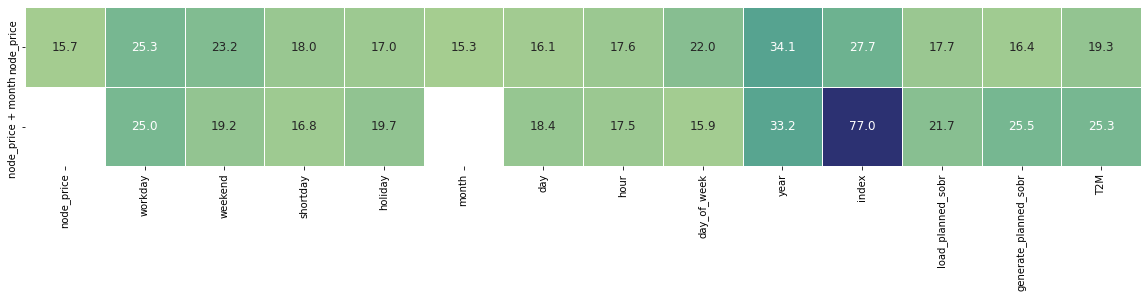

In [10]:
import seaborn as sns

plt.figure(figsize=(20, 20))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(results, cmap=cmap, square=True, linewidths=.5, cbar=False, annot=True, fmt=".1f", annot_kws={"size":12})